<a href="https://colab.research.google.com/github/iqranaz240/Cluster-Validity-Analysis/blob/main/IqraNaz_23K_8043_Assignment02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset from Kaggle Competition

# Home Credit - Credit Risk Model Stability


In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'home-credit-credit-risk-model-stability:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F50160%2F7921029%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240423%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240423T191644Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9d6b61c492af505bf452a65be65c817ed980238eb5eed078b025f99830863ced470c6275bfdb6a75ed60dadc701d628820de558c753581f884ff45b7a11bffc4356d07cb29368382a08a6e4c280ff9a4b3646ac925f9bf3023b1bc58667530c4ef942a7ed9bb914dcdc927363812a11f058335d8919ef8426da240c0438b4af26ddef9a9c3cc5b8152c41fe6d5b4c574992be2b834d08fe4d308231f9d14b79e8cffa8a6cc8f46400a661f474efc098f3c0e84143732faebe88ef845048187d2293ae99a7b6e63b6aea64d235a744777407a3443af46fe8381553da4976f67bdb3c1441b61ff73383b0667f0ccc35dba5a3d3fac1004246b8782cb2ab7e9a098'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
import missingno as mso
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Load Data

This data is taken from a Kaggle Competition I have selected for my semester project.

In [ ]:
dataPath = "/kaggle/input/home-credit-credit-risk-model-stability/"

# Dataset Preparation

In [ ]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:

    for col in df.columns:
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

In [ ]:
train_basetable = pl.read_csv(dataPath + "csv_files/train/train_base.csv")
train_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_csv(dataPath + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(dataPath + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes)
train_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes)

In [ ]:
test_basetable = pl.read_csv(dataPath + "csv_files/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(dataPath + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(dataPath + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes)
test_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes)

In [ ]:
# We need to use aggregation functions in tables with depth > 1, so tables that contain num_group1 column or
# also num_group2 column.
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

# Here num_group1=0 has special meaning, it is the person who applied for the loan.
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Here we have num_goup1 and num_group2, so we need to aggregate again.
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

# We will process in this examples only A-type and M-type columns, so we need to select them.
selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M"):
        selected_static_cols.append(col)
print(selected_static_cols)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M"):
        selected_static_cb_cols.append(col)
print(selected_static_cb_cols)

# Join all tables together.
df = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [ ]:
df.shape

(1526659, 58)

In [ ]:
test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

data_submission = test_basetable.join(
    test_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats_1, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

In [ ]:
case_ids = df["case_id"].unique().shuffle(seed=1)
case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.6, random_state=1)
case_ids_valid, case_ids_test = train_test_split(case_ids_test, train_size=0.5, random_state=1)

cols_pred = []
for col in df.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)

print(cols_pred)

def from_polars_to_pandas(case_ids: pl.DataFrame) -> pl.DataFrame:
    return (
        df.filter(pl.col("case_id").is_in(case_ids))[["case_id", "WEEK_NUM", "target"]].to_pandas(),
        df.filter(pl.col("case_id").is_in(case_ids))[cols_pred].to_pandas(),
        df.filter(pl.col("case_id").is_in(case_ids))["target"].to_pandas()
    )

base_train, X_train, y_train = from_polars_to_pandas(case_ids_train)
base_valid, X_valid, y_valid = from_polars_to_pandas(case_ids_valid)
base_test, X_test, y_test = from_polars_to_pandas(case_ids_test)

for df in [X_train, X_valid, X_test]:
    df = convert_strings(df)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

# Data Exploration

In [ ]:
df = pd.concat([X_train, y_train], axis=1)

In [ ]:
df.describe()

,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,avginstallast24m_3658937A,avglnamtstart24m_4525187A,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,credamount_770A,currdebt_22A,currdebtcredtyperange_828A,...,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,pmtaverage_3A,pmtaverage_4527227A,pmtaverage_4955615A,pmtssum_45A,target
count,5.791220e+05,915995.000000,915994.000000,541137.000000,97373.000000,4.113760e+05,299622.000000,915995.000000,9.159940e+05,9.159940e+05,...,6.486920e+05,4.116090e+05,9.159940e+05,9.159940e+05,211305.000000,86118.000000,68821.000000,43159.000000,343834.000000,915995.000000
mean,5.605103e+04,4039.997497,1438.738468,5399.340343,44660.797975,4.598377e+04,6398.226506,49875.792736,1.971436e+04,1.101732e+04,...,2.773474e+04,2.827702e+04,1.971514e+04,9.245970e+04,10417.497928,9314.901329,10052.182398,17616.446469,13232.382356,0.031520
std,7.168848e+04,3011.036962,2809.423625,6436.574978,44763.150187,6.441692e+04,9204.315939,44182.879524,5.090623e+04,3.683703e+04,...,5.849688e+04,6.042809e+04,5.090734e+04,1.686761e+05,16187.276163,5568.038917,5530.822134,6777.177534,18190.787187,0.174718
min,0.000000e+00,83.000000,0.000000,0.000000,0.000000,-7.588198e+06,0.000000,2000.000000,0.000000e+00,0.000000e+00,...,-2.405000e+03,-2.405000e+03,0.000000e+00,0.000000e+00,0.222000,0.000000,5.000000,6.000000,0.000000,0.000000
25%,7.451650e+03,1968.200100,0.000000,2529.800000,15685.800000,8.719109e+03,2595.200000,19998.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3314.600000,6590.600000,7192.200000,13649.400000,3167.616000,0.000000
50%,2.975565e+04,3151.600000,0.000000,4071.600000,28460.800000,2.278338e+04,4422.000000,35190.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,3.590924e+04,6216.000000,7305.900000,7553.000000,15765.601000,8400.000000,0.000000
75%,7.652577e+04,5231.400000,2038.800000,6553.000000,56377.800000,5.536972e+04,7516.200000,63984.000000,1.355695e+04,0.000000e+00,...,2.807435e+04,2.796280e+04,1.355776e+04,1.190084e+05,11697.601000,13027.475000,13464.400000,21829.500500,17005.658500,0.000000
max,1.198913e+06,91601.400000,71878.600000,496148.800000,513520.000000,1.131136e+06,495910.400000,950000.000000,1.210629e+06,1.028338e+06,...,1.210629e+06,1.085048e+06,1.210629e+06,4.803504e+07,794899.200000,145257.400000,205848.610000,99085.400000,476843.400000,1.000000


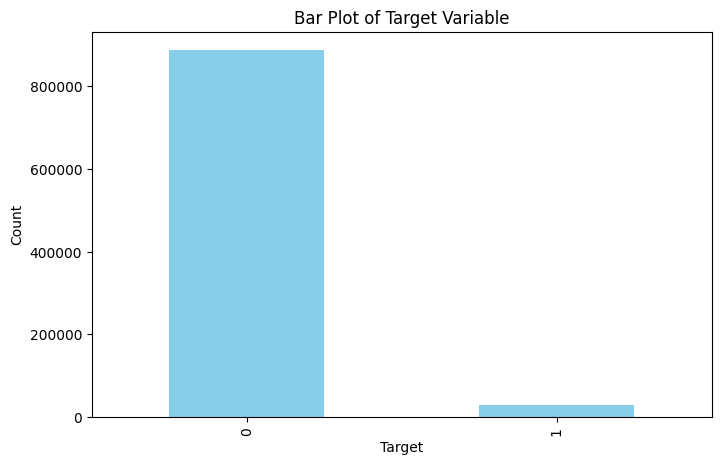

In [ ]:
target_counts = df['target'].value_counts()

plt.figure(figsize=(8, 5))
target_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Bar Plot of Target Variable')
plt.show()

# Data Cleaning

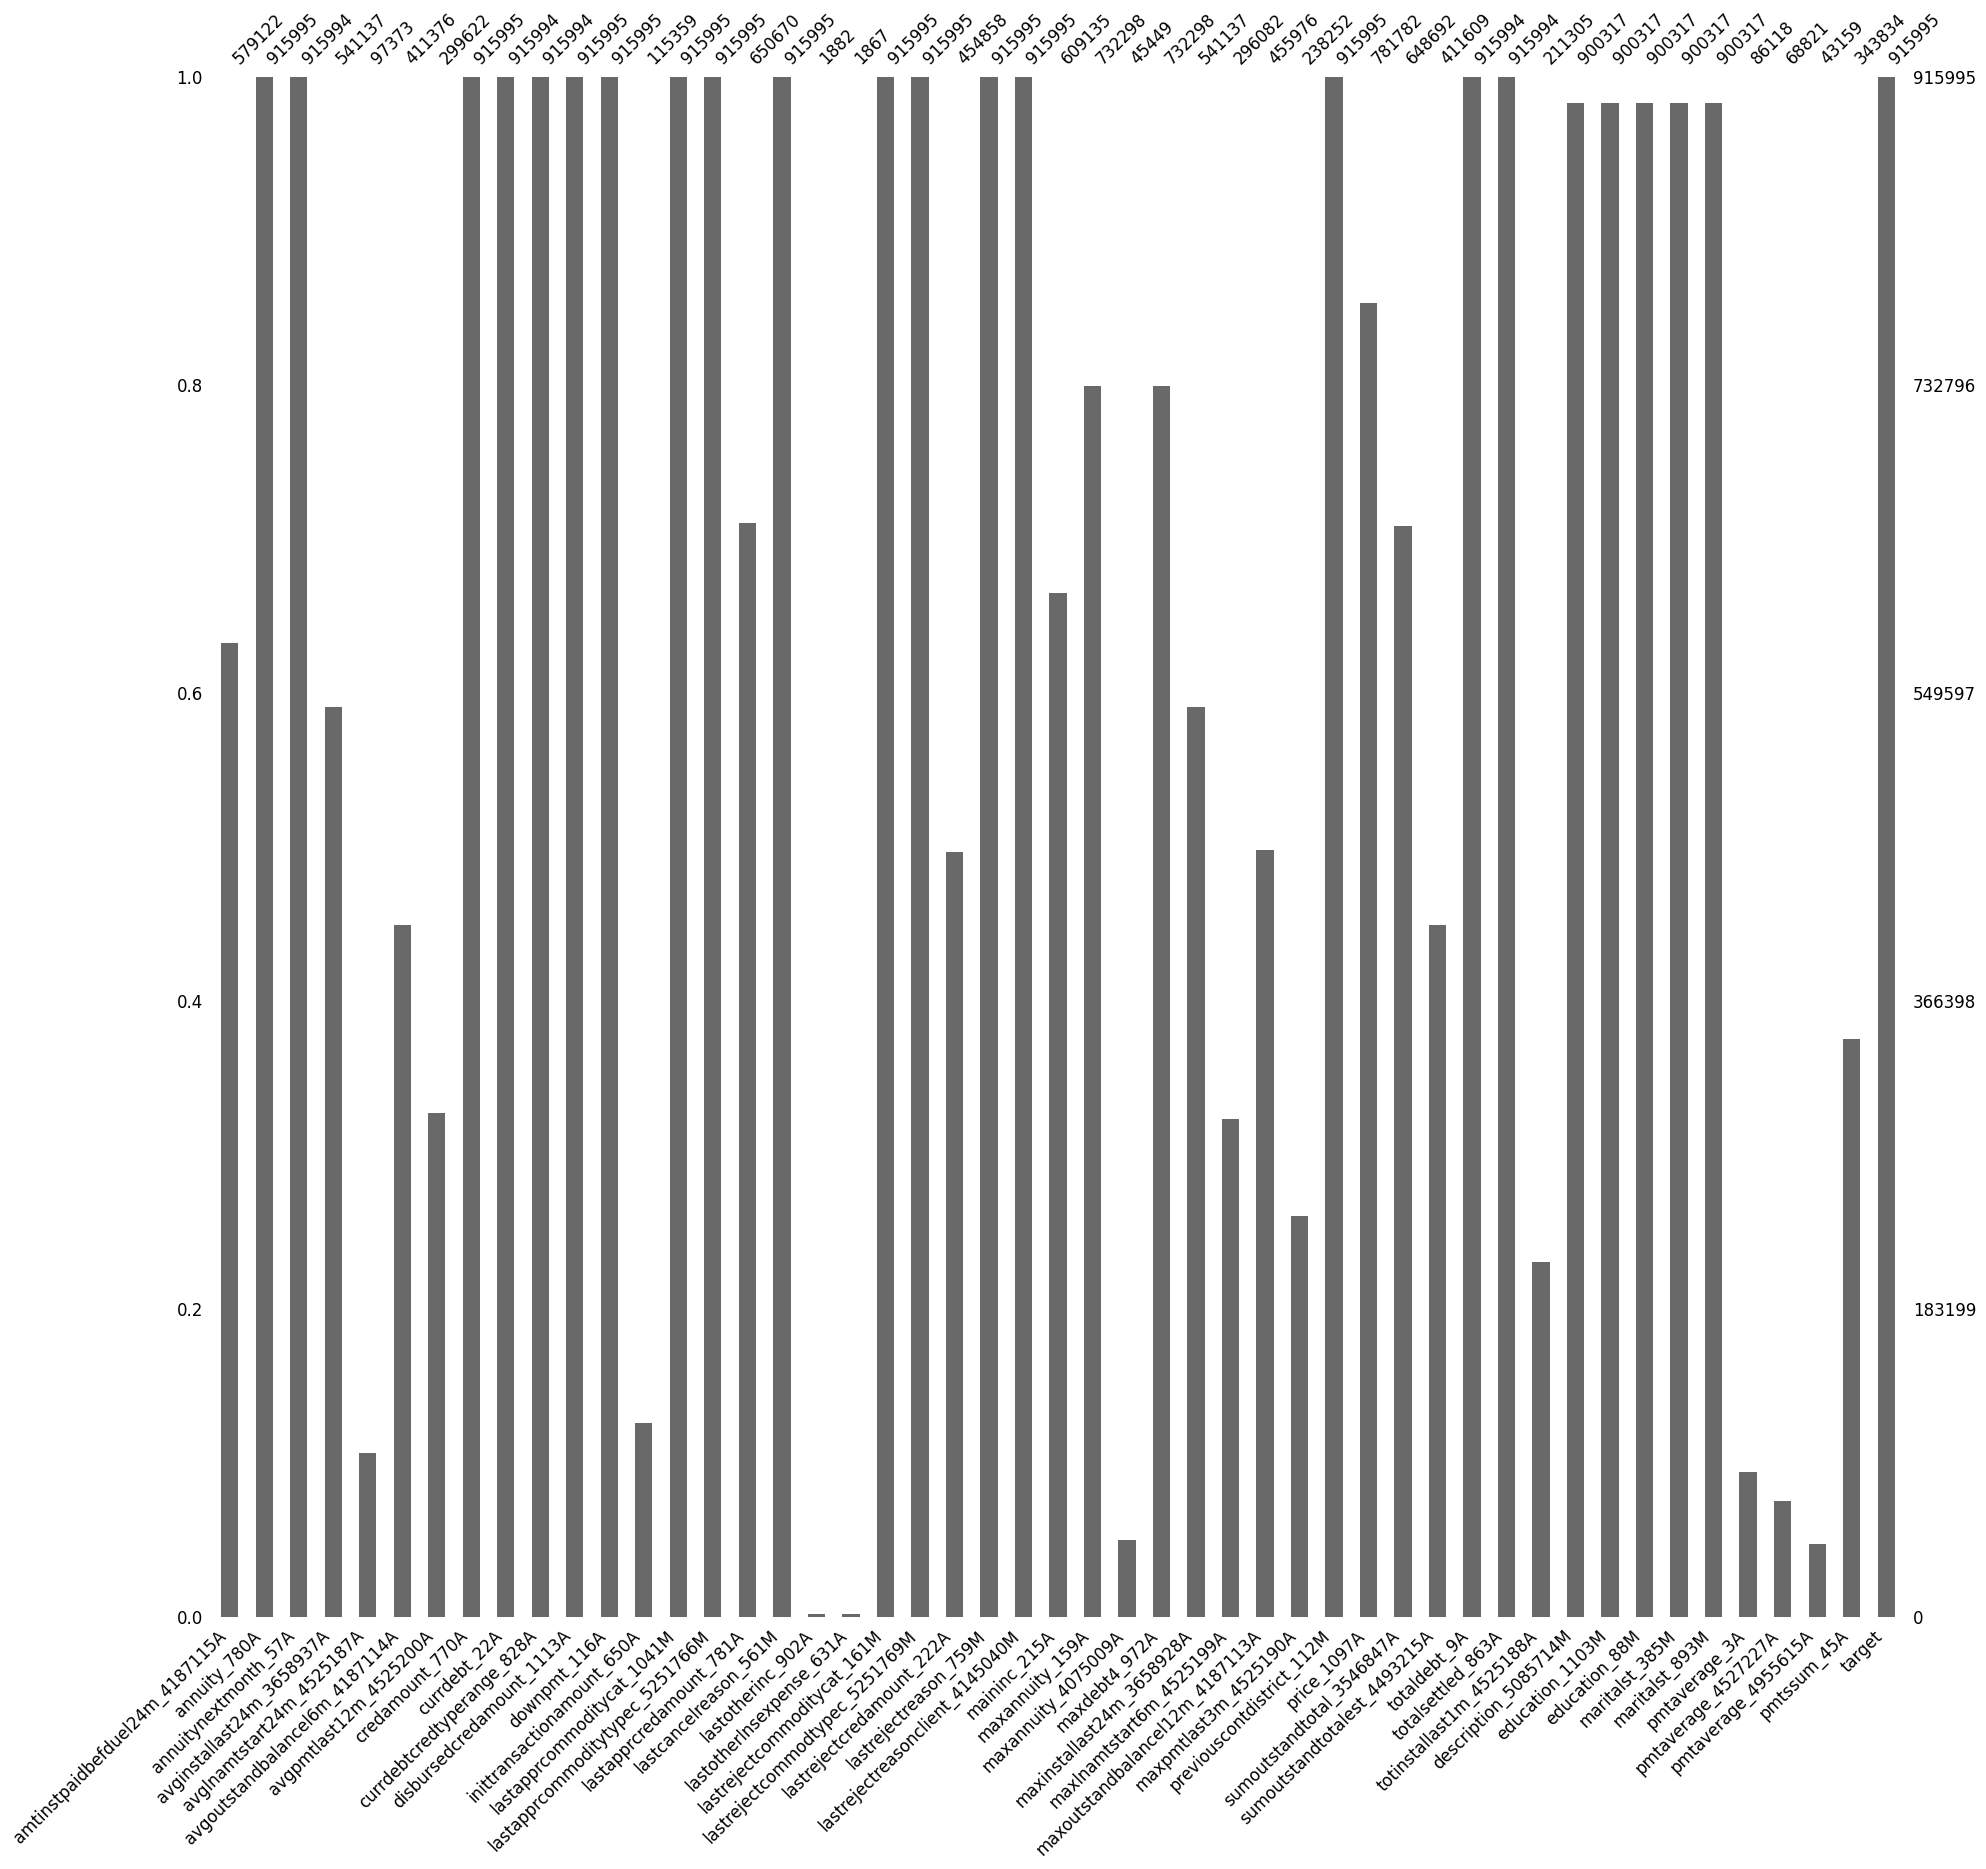

In [ ]:
import missingno as mso
plt.figure(figsize=(48,20))
axz=plt.subplot(1,2,2)
mso.bar(df, ax=axz,fontsize=12);

In [ ]:
# Check for duplicates
duplicates = df.duplicated()
print("\nNumber of Duplicate Rows:", df[duplicates].shape[0])
print(df[duplicates])

df = df.drop_duplicates()


Number of Duplicate Rows: 8259
        amtinstpaidbefduel24m_4187115A  annuity_780A  annuitynextmonth_57A  \
12                                 NaN     1218.0000                   0.0   
47                                 NaN     1218.0000                   0.0   
83                                 NaN     3779.4001                   0.0   
89                                 NaN     6000.0000                   0.0   
129                                NaN     4744.8003                   0.0   
...                                ...           ...                   ...   
385882                             NaN     2874.2000                   0.0   
385972                             NaN     5831.8003                   0.0   
437851                            0.00    15022.4000                   0.0   
458226                            0.00     4963.6000                   0.0   
508267                       131575.08     3527.6000                   0.0   

        avginstallast24m_365893

In [ ]:
null_counts = df.isnull().sum()

# Calculate the percentage of null values in each column
total_rows = len(df)
null_percentages = (null_counts / total_rows) * 100

# Identify columns with more than 50% null values
threshold_percentage = 50
columns_to_drop = null_percentages[null_percentages > threshold_percentage].index.tolist()

# Drop columns with more than 50% null values
df = df.drop(columns=columns_to_drop)

# Print the number of null values in each column and the resulting DataFrame after dropping columns
print("\nPercentage of null values in each column:")
print(null_percentages)
print("\nDataFrame after dropping columns:")
print(df)


Percentage of null values in each column:
amtinstpaidbefduel24m_4187115A     36.201825
annuity_780A                        0.000000
annuitynextmonth_57A                0.000110
avginstallast24m_3658937A          40.386192
avglnamtstart24m_4525187A          89.272982
avgoutstandbalancel6m_4187114A     54.681207
avgpmtlast12m_4525200A             66.992385
credamount_770A                     0.000000
currdebt_22A                        0.000110
currdebtcredtyperange_828A          0.000110
disbursedcredamount_1113A           0.000000
downpmt_116A                        0.000000
inittransactionamount_650A         87.603224
lastapprcommoditycat_1041M          0.000000
lastapprcommoditytypec_5251766M     0.000000
lastapprcredamount_781A            28.319798
lastcancelreason_561M               0.000000
lastotherinc_902A                  99.792671
lastotherlnsexpense_631A           99.794323
lastrejectcommoditycat_161M         0.000000
lastrejectcommodtypec_5251769M      0.000000
lastrejectcr

In [ ]:
from sklearn.impute import SimpleImputer

numerical_columns = df.select_dtypes(include=['number']).columns
categorical_columns = df.select_dtypes(include=['category']).columns

# Impute numerical columns with mean
numerical_imputer = SimpleImputer(strategy='mean')
df[numerical_columns] = numerical_imputer.fit_transform(df[numerical_columns])

# Impute categorical columns with mode
categorical_imputer = SimpleImputer(strategy='most_frequent')
df[categorical_columns] = categorical_imputer.fit_transform(df[categorical_columns])

In [ ]:
target_counts = df['target'].value_counts()
print(target_counts)

target
0.0    878889
1.0     28847
Name: count, dtype: int64


In [ ]:
data_types = df.dtypes
data_types

amtinstpaidbefduel24m_4187115A     float64
annuity_780A                       float64
annuitynextmonth_57A               float64
avginstallast24m_3658937A          float64
credamount_770A                    float64
currdebt_22A                       float64
currdebtcredtyperange_828A         float64
disbursedcredamount_1113A          float64
downpmt_116A                       float64
lastapprcommoditycat_1041M          object
lastapprcommoditytypec_5251766M     object
lastapprcredamount_781A            float64
lastcancelreason_561M               object
lastrejectcommoditycat_161M         object
lastrejectcommodtypec_5251769M      object
lastrejectcredamount_222A          float64
lastrejectreason_759M               object
lastrejectreasonclient_4145040M     object
maininc_215A                       float64
maxannuity_159A                    float64
maxdebt4_972A                      float64
maxinstallast24m_3658928A          float64
maxoutstandbalancel12m_4187113A    float64
previouscon

In [ ]:
df.shape

(907736, 34)

In [ ]:
# Extract 50000 rows using .iloc indexer. Did this because all data samples are unable to be processed. Asked Sir Shahzad about it in class already.
rows_to_extract = 50000
df = df.iloc[:rows_to_extract]

In [ ]:
df.shape

(50000, 34)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 0 to 50707
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   amtinstpaidbefduel24m_4187115A   50000 non-null  float64
 1   annuity_780A                     50000 non-null  float64
 2   annuitynextmonth_57A             50000 non-null  float64
 3   avginstallast24m_3658937A        50000 non-null  float64
 4   credamount_770A                  50000 non-null  float64
 5   currdebt_22A                     50000 non-null  float64
 6   currdebtcredtyperange_828A       50000 non-null  float64
 7   disbursedcredamount_1113A        50000 non-null  float64
 8   downpmt_116A                     50000 non-null  float64
 9   lastapprcommoditycat_1041M       50000 non-null  object 
 10  lastapprcommoditytypec_5251766M  50000 non-null  object 
 11  lastapprcredamount_781A          50000 non-null  float64
 12  lastcancelreason_561M  

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

categorical_cols = df.select_dtypes(include=['category', 'object']).columns

In [ ]:
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Using KMeans Clustering

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(df.drop(columns=['target']))
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


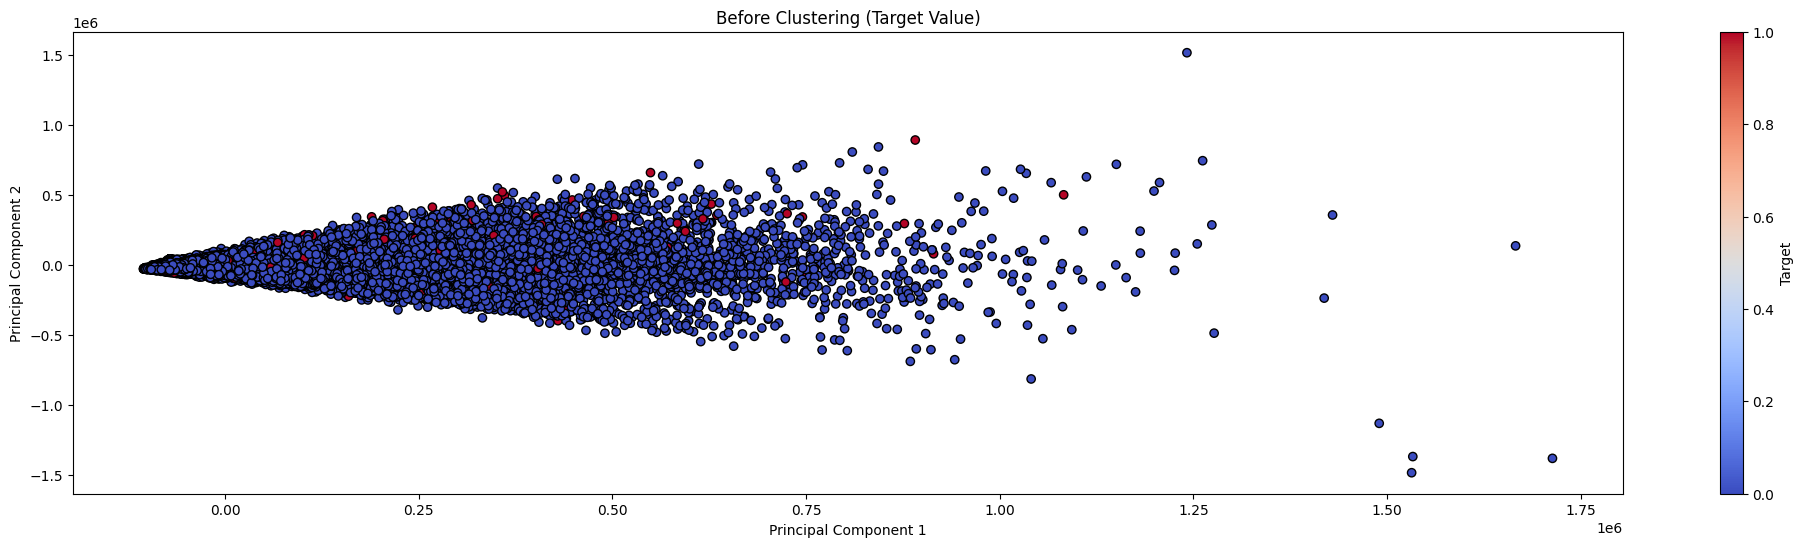

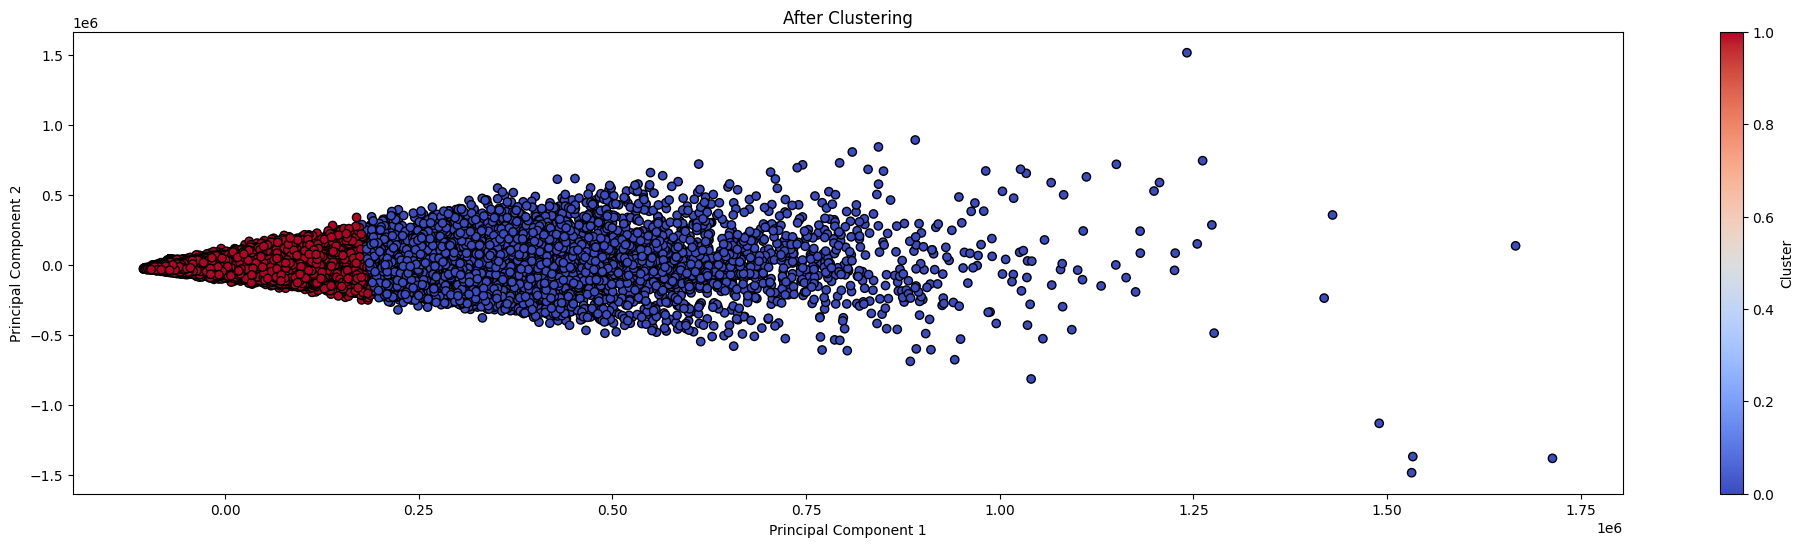

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df)

# Plot before clustering with target value
plt.figure(figsize=(25, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df['target'], cmap='coolwarm', marker='o', edgecolor='black')
plt.title('Before Clustering (Target Value)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Target')

# Plot after clustering
plt.figure(figsize=(25, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='coolwarm', marker='o', edgecolor='black')
plt.title('After Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()



Switching from k-means to agglomerative clustering. K-means clustering, while efficient and straightforward to implement, containing irregularly shaped or overlapping clusters. This lead to improved clustering results and deeper insights into the underlying patterns present in the dataset.

# Using Agglomerative Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Initialize and fit Agglomerative Hierarchical Clustering
agg_clustering = AgglomerativeClustering(n_clusters=2, linkage='ward')
cluster_labels_agg = agg_clustering.fit_predict(df.drop(columns=['target']))

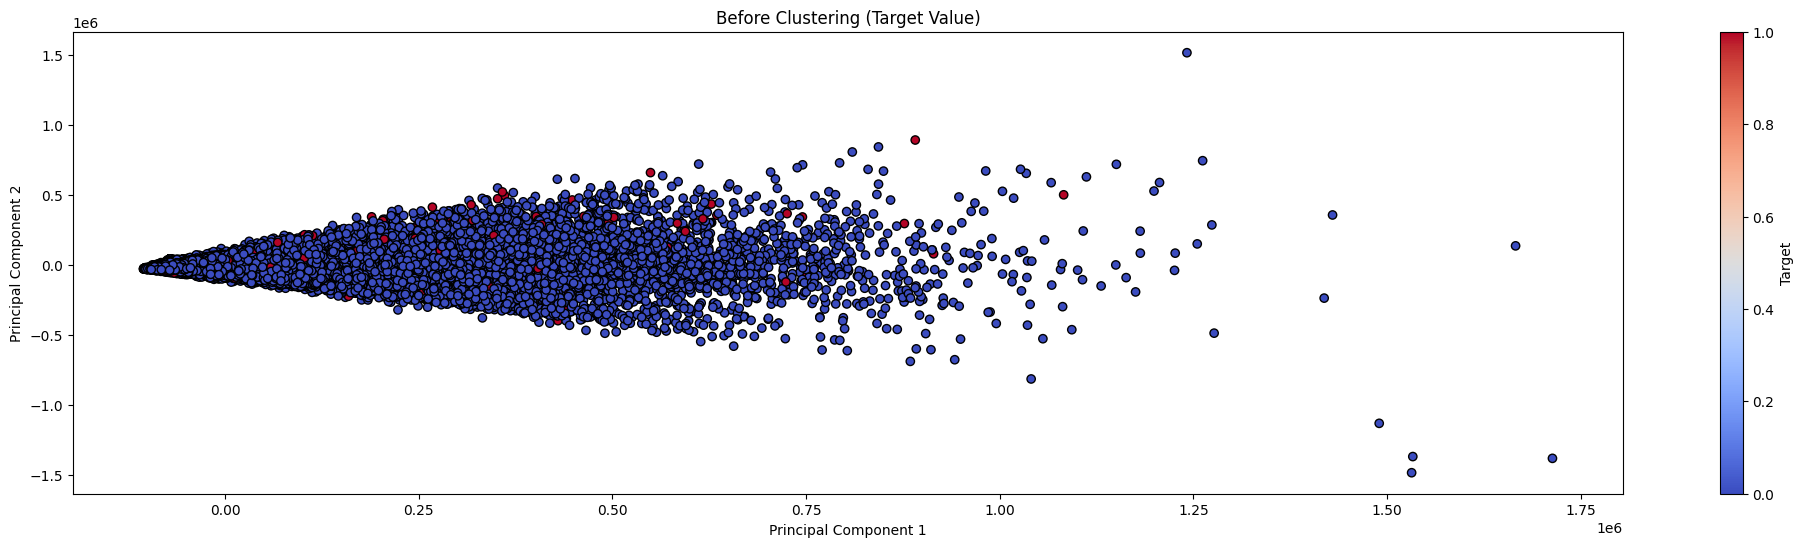

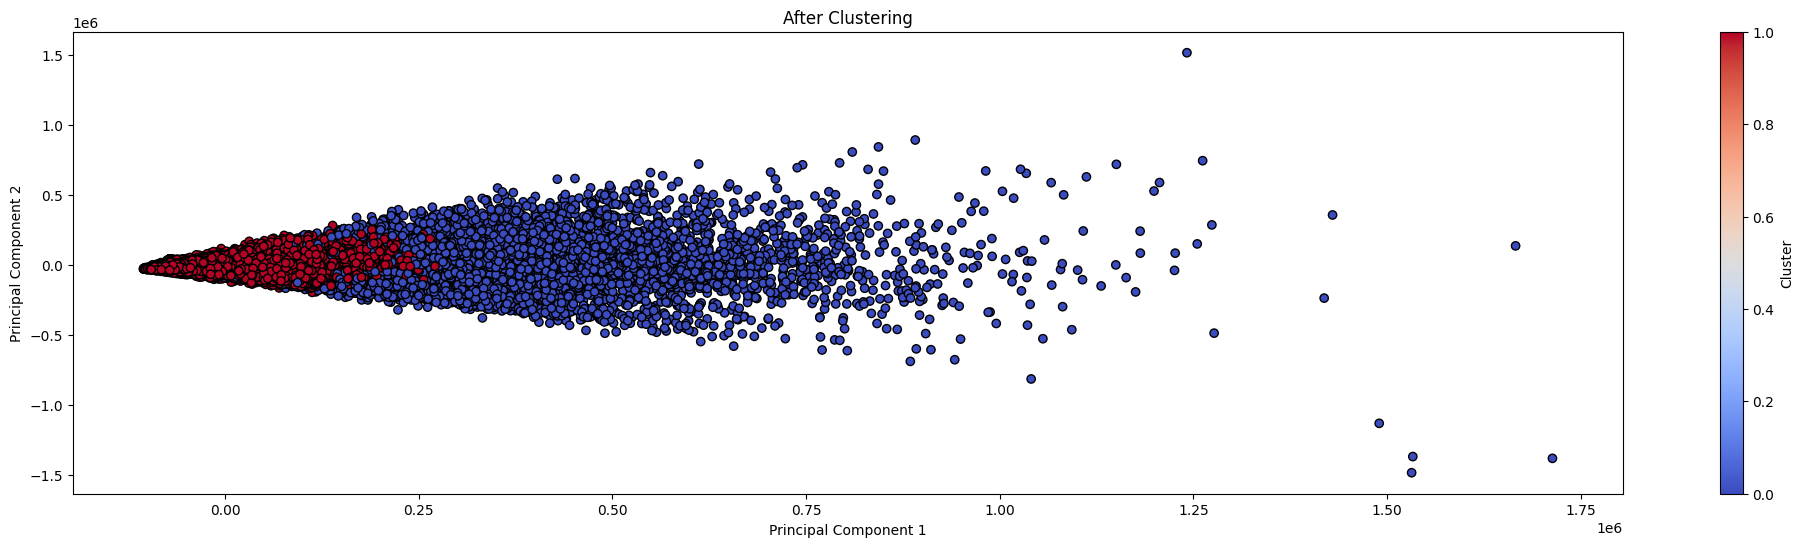

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensionality to 2D using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df)

# Plot before clustering with target value
plt.figure(figsize=(25, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df['target'], cmap='coolwarm', marker='o', edgecolor='black')
plt.title('Before Clustering (Target Value)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Target')

# Plot after clustering
plt.figure(figsize=(25, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels_agg, cmap='coolwarm', marker='o', edgecolor='black')
plt.title('After Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances

def calculate_entropy(labels):
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    proportions = label_counts / len(labels)
    entropy = -np.sum(proportions * np.log2(proportions))
    return entropy

def calculate_purity(labels, true_labels):
    total_points = len(labels)
    purity = 0
    unique_labels = np.unique(labels)
    for cluster_label in unique_labels:
        cluster_indices = np.where(labels == cluster_label)[0]
        cluster_true_labels = true_labels.iloc[cluster_indices]  # assuming true_labels is a DataFrame
        majority_class_count = np.max(np.bincount(cluster_true_labels))
        purity += majority_class_count
    purity /= total_points
    return purity

cluster_entropy = calculate_entropy(cluster_labels_agg)
cluster_purity = calculate_purity(cluster_labels_agg, df['target'])

print("Entropy of clusters:", cluster_entropy)
print("Purity of clusters:", cluster_purity)

Entropy of clusters: 0.49967460685299064
Purity of clusters: 0.9678


Entropy: The clusters exhibit relatively low entropy, indicating reasonable separation between clusters.

Purity: The clusters are highly pure, with the majority of data points belonging to the same class within each cluster.

Above values suggest that the clustering algorithm has effectively grouped similar data points together into distinct clusters, with relatively little overlap between clusters and high consistency of class labels within clusters.

In [ ]:
import numpy as np
from sklearn.metrics import pairwise_distances

def calculate_cluster_cohesion(cluster_labels, df):
    unique_labels = np.unique(cluster_labels)
    cohesion_scores = []
    for label in unique_labels:
        cluster_data = df.loc[cluster_labels == label]
        pairwise_dist = pairwise_distances(cluster_data)
        cohesion_score = np.mean(pairwise_dist)
        cohesion_scores.append(cohesion_score)
    return np.mean(cohesion_scores)

def calculate_cluster_separation(cluster_labels, X):
    num_clusters = len(np.unique(cluster_labels))
    separation_scores = []

    # Calculate cluster centers
    cluster_centers = []
    for label in np.unique(cluster_labels):
        cluster_centers.append(np.mean(X[cluster_labels == label], axis=0))
    cluster_centers = np.array(cluster_centers)

    # Calculate the distances between cluster centroids
    for i in range(num_clusters):
        for j in range(i + 1, num_clusters):
            centroid_i = cluster_centers[i]
            centroid_j = cluster_centers[j]
            separation_score = np.linalg.norm(centroid_i - centroid_j)
            separation_scores.append(separation_score)

    # Calculate the average separation score
    if separation_scores:
        separation = np.mean(separation_scores)
    else:
        separation = 0.0

    return separation


# Calculate cluster cohesion
cohesion = calculate_cluster_cohesion(cluster_labels_agg, df.drop(columns=['target']))

# Calculate cluster separation (assuming 'cluster_centers' contains the centroids)
separation = calculate_cluster_separation(cluster_labels_agg, df.drop(columns=['target']))

print("Cluster Cohesion:", cohesion)
print("Cluster Separation:", separation)


Cluster Cohesion: 287517.24162750423
Cluster Separation: 441288.0912227491


Cluster Cohesion: The cluster cohesion is 287517. This value represents the average distance between all pairs of points within the same cluster indicates the data points within each cluster are closer to each other, indicating better intra-cluster similarity and tighter clustering.

Cluster Separation: The cluster separation using centroid distance is 441288. This value represents the average distance between centroids of different clusters indicates clusters are distinct from each other and better inter-cluster dissimilarity and effective clustering.

The relatively low cluster cohesion indicates that the data points within each cluster are tightly packed together, suggesting good intra-cluster similarity.
The relatively high cluster separation using centroid distance indicates that the clusters are well-separated from each other, suggesting good inter-cluster dissimilarity and effective clustering. The cluster separation is higher than the cluster cohesion, indicating that the clusters are well-separated, which is generally a good sign for clustering performance.

# Interpretation

## 1. Entropy:
The entropy value  obtained is 0.449, which is relatively low. This suggests that there is some level of uncertainty or disorder within the clusters, indicating that the clusters may not be perfectly separated.
However, despite the relatively low entropy, it's still within a reasonable range, indicating that the clusters are reasonably well-defined and internally consistent. This means that data points within each cluster are somewhat similar to each other and dissimilar to points in other clusters.

## 2. Purity:
The purity score obtained is 0.967, which is quite high. This suggests that the clusters are highly pure, meaning that the majority of data points within each cluster belong to the same class or category.
A purity score of 0.96 indicates that 96% of the data points in the clusters belong to the dominant class within each cluster. This high purity score suggests that the clustering algorithm has effectively grouped similar data points together into clusters that align well with the true classes or categories in the dataset.

## 3. Cluster Cohesion:
The cluster cohesion value obtained is 287517. This value represents the average distance between all pairs of points within the same cluster.
A relatively low cluster cohesion value indicates that the data points within each cluster are tightly packed together, suggesting good intra-cluster similarity.

## 4. Cluster Separation:
The cluster separation using centroid distance is 441288. This value represents the average distance between centroids of different clusters.
A higher separation value suggests that the clusters are more distinct from each other, indicating better inter-cluster dissimilarity and more effective clustering.


The relatively low entropy value suggests that while there may be some overlap or uncertainty within the clusters, the clusters are still reasonably well-separated and internally consistent.
The high purity score further confirms that the clusters accurately represent the true classes or categories in the dataset.
The relatively low cluster cohesion value indicates that the data points within each cluster are tightly packed together, indicating good intra-cluster similarity.
The high cluster separation value using centroid distance suggests that the clusters are well-separated from each other, indicating good inter-cluster dissimilarity and effective clustering.
Overall, these metrics collectively suggest that the clustering algorithm has effectively grouped similar data points together into distinct clusters while keeping the clusters well-separated from each other, accurately representing the underlying structure of the data.

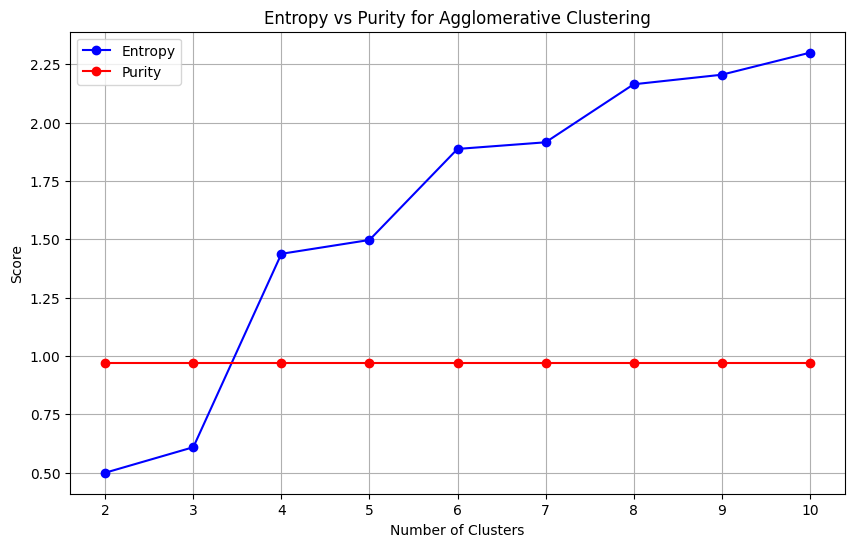

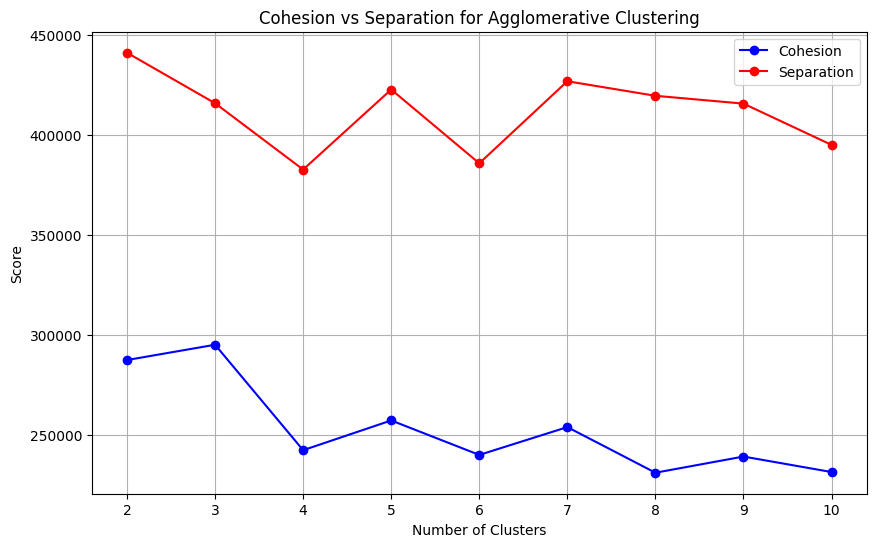

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import AgglomerativeClustering

# Vary number of clusters
num_clusters_range = range(2, 11)
entropies = []
purities = []
cohesions = []
separations = []

for n_clusters in num_clusters_range:
    # Initialize and fit Agglomerative Hierarchical Clustering
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')  # Adjust linkage method as needed
    cluster_labels = agg_clustering.fit_predict(df.drop(columns=['target']))

    # Calculate entropy and purity
    entropy_score = calculate_entropy(cluster_labels)
    purity_score = calculate_purity(cluster_labels, df['target'])
    entropies.append(entropy_score)
    purities.append(purity_score)

    # Calculate cohesion and separation
    cohesion_score = calculate_cluster_cohesion(cluster_labels, df.drop(columns=['target']))
    separation_score = calculate_cluster_separation(cluster_labels, df.drop(columns=['target']))
    cohesions.append(cohesion_score)
    separations.append(separation_score)

# Plot entropy vs purity
plt.figure(figsize=(10, 6))
plt.plot(num_clusters_range, entropies, marker='o', label='Entropy', color='blue')
plt.plot(num_clusters_range, purities, marker='o', label='Purity', color='red')
plt.title('Entropy vs Purity for Agglomerative Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot cohesion vs separation
plt.figure(figsize=(10, 6))
plt.plot(num_clusters_range, cohesions, marker='o', label='Cohesion', color='blue')
plt.plot(num_clusters_range, separations, marker='o', label='Separation', color='red')
plt.title('Cohesion vs Separation for Agglomerative Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


The graph compares the performance of agglomerative clustering over different number of clusters based on two metrics: entropy-purity and cohesion-separation.

The graph shows that agglomerative clustering generally achieves lower entropy (higher purity) and lower separation, indicating better clustering performance. This suggests that agglomerative clustering may be more effective in creating clusters that are internally homogeneous and well-separated from each other, potentially leading to more meaningful and accurate clustering results.

The above graph indicates that entropy increased with increase in number of clusters in my case while purity remains constant. Whereas cohesion and separation decreased with increasing number of clusters.

Graphs indicates that while entropy tends to increase with an increasing number of clusters, suggesting higher uncertainty within clusters, purity remains relatively constant, indicating consistent class membership within clusters. Meanwhile, cohesion and separation decrease with more clusters, suggesting decreased tightness within clusters and reduced distinctiveness between clusters. This implies that increasing the number of clusters leads to finer granularity in the clustering solution but may also result in less well-defined and more fragmented clusters. Therefore, there appears to be a trade-off between cluster granularity and quality, with the optimal number of clusters balancing these factors to achieve meaningful clustering results.